In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
#import utils
import models
import model
from torchsummary import summary
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pdb
import albumentations as A
import DataAugmentations as Aug
import torch.nn as nn

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

inttoclasses = {i:classes for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
#Mean Train
print(Aug.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(Aug.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(Aug.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(Aug.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [5]:
training_iterator = iter(Aug.train_loader)

In [6]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

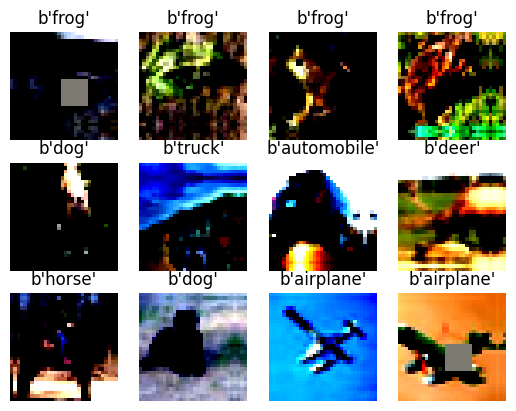

In [7]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [2]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [3]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [4]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, scheduler,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    #pdb.set_trace()
    #loss = F.nll_loss(y_pred, target)
    loss = criterion(y_pred, target)
    train_losses.append(loss)
    lrs.append(get_lr(optimizer))
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    scheduler.step()
    # Update pbar-tqdm
    #pdb.set_trace()
    _, pred = torch.max(y_pred.data, 1)
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(lr)
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()
            _, pred = torch.max(output.data, 1)
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    #pdb.set_trace()
    # misclassified_images = data[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_actual_label = target[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_predicted_label = pred[(pred != target.view_as(pred)).view(-1)].squeeze(1)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss


In [5]:
device

'mps'

In [6]:
# model = models.model().to(device= device)

model = model.CustomResNet().to(device)

/Users/mouzam/TSAI/.venv/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 66%|██████▌   | 132/200 [01:14<00:38,  1.77it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.07E-02


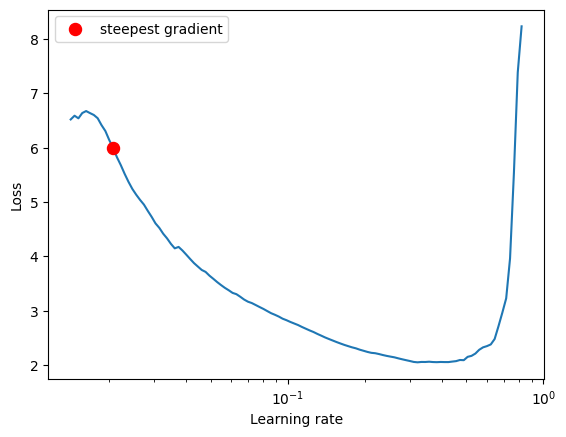

In [7]:
from torch_lr_finder import LRFinder

# #model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01, weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(Aug.train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [8]:

#optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
num_epochs = 24

#max_lr=4.38E-02
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2.07E-02, steps_per_epoch=len(Aug.train_loader), epochs=num_epochs,
                                                pct_start= 5/num_epochs, 
                                                div_factor = 100, 
                                                three_phase= False,
                                                final_div_factor=100,
                                                anneal_strategy = 'linear',
                                                verbose= False)
# New Line

#criterion = nn.CrossEntropyLoss()

#criterion_test = nn.CrossEntropyLoss(reduction='sum')

   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, Aug.train_loader, optimizer, scheduler,criterion)
    test_loss = test(model, device, Aug.test_loader,criterion)
    #scheduler.step(test_loss)


Epoch 1


Loss=1.0156217813491821 Batch_id=97 Accuracy=51.83: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]



Test set: Average loss: 0.0021, Accuracy: 6305/10000 (63.05%)

Epoch 2


Loss=0.7345882654190063 Batch_id=97 Accuracy=67.64: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0022, Accuracy: 6422/10000 (64.22%)

Epoch 3


Loss=0.9030867218971252 Batch_id=97 Accuracy=72.86: 100%|██████████| 98/98 [01:01<00:00,  1.60it/s]



Test set: Average loss: 0.0021, Accuracy: 6824/10000 (68.24%)

Epoch 4


Loss=0.9714550971984863 Batch_id=97 Accuracy=73.99: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0020, Accuracy: 6874/10000 (68.74%)

Epoch 5


Loss=0.5647683143615723 Batch_id=97 Accuracy=77.81: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0016, Accuracy: 7300/10000 (73.00%)

Epoch 6


Loss=0.6641881465911865 Batch_id=97 Accuracy=81.27: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0016, Accuracy: 7337/10000 (73.37%)

Epoch 7


Loss=0.4725198447704315 Batch_id=97 Accuracy=83.34: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s] 



Test set: Average loss: 0.0014, Accuracy: 7534/10000 (75.34%)

Epoch 8


Loss=0.4518931210041046 Batch_id=97 Accuracy=84.21: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s] 



Test set: Average loss: 0.0012, Accuracy: 8050/10000 (80.50%)

Epoch 9


Loss=0.3674810528755188 Batch_id=97 Accuracy=85.16: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0011, Accuracy: 8189/10000 (81.89%)

Epoch 10


Loss=0.46140721440315247 Batch_id=97 Accuracy=86.05: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0014, Accuracy: 7646/10000 (76.46%)

Epoch 11


Loss=0.3383921682834625 Batch_id=97 Accuracy=86.33: 100%|██████████| 98/98 [10:41<00:00,  6.55s/it]    



Test set: Average loss: 0.0011, Accuracy: 8210/10000 (82.10%)

Epoch 12


Loss=0.3240434229373932 Batch_id=97 Accuracy=87.33: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s] 



Test set: Average loss: 0.0010, Accuracy: 8258/10000 (82.58%)

Epoch 13


Loss=0.3882819712162018 Batch_id=97 Accuracy=87.60: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0010, Accuracy: 8271/10000 (82.71%)

Epoch 14


Loss=0.37017160654067993 Batch_id=97 Accuracy=87.71: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0009, Accuracy: 8420/10000 (84.20%)

Epoch 15


Loss=0.32587572932243347 Batch_id=97 Accuracy=88.63: 100%|██████████| 98/98 [01:00<00:00,  1.63it/s]



Test set: Average loss: 0.0012, Accuracy: 8114/10000 (81.14%)

Epoch 16


Loss=0.3432346284389496 Batch_id=97 Accuracy=89.27: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0009, Accuracy: 8525/10000 (85.25%)

Epoch 17


Loss=0.2848048210144043 Batch_id=97 Accuracy=90.06: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0009, Accuracy: 8528/10000 (85.28%)

Epoch 18


Loss=0.23256860673427582 Batch_id=97 Accuracy=90.54: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0009, Accuracy: 8502/10000 (85.02%)

Epoch 19


Loss=0.2314421385526657 Batch_id=97 Accuracy=91.31: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0009, Accuracy: 8590/10000 (85.90%)

Epoch 20


Loss=0.1907540261745453 Batch_id=97 Accuracy=91.97: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s] 



Test set: Average loss: 0.0008, Accuracy: 8622/10000 (86.22%)

Epoch 21


Loss=0.20698393881320953 Batch_id=97 Accuracy=93.27: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0007, Accuracy: 8806/10000 (88.06%)

Epoch 22


Loss=0.1387779712677002 Batch_id=97 Accuracy=94.52: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0006, Accuracy: 8974/10000 (89.74%)

Epoch 23


Loss=0.13934749364852905 Batch_id=97 Accuracy=95.86: 100%|██████████| 98/98 [07:27<00:00,  4.56s/it]   



Test set: Average loss: 0.0006, Accuracy: 9069/10000 (90.69%)

Epoch 24


Loss=0.0768229141831398 Batch_id=97 Accuracy=96.70: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s] 



Test set: Average loss: 0.0005, Accuracy: 9114/10000 (91.14%)



In [13]:
lrs

[0.000493,
 0.0005928098159509202,
 0.0006926196319018404,
 0.0007924294478527606,
 0.0008922392638036809,
 0.0009920490797546012,
 0.0010918588957055213,
 0.0011916687116564416,
 0.0012914785276073619,
 0.0013912883435582822,
 0.0014910981595092025,
 0.0015909079754601225,
 0.0016907177914110428,
 0.0017905276073619631,
 0.0018903374233128832,
 0.0019901472392638035,
 0.002089957055214724,
 0.002189766871165644,
 0.0022895766871165644,
 0.0023893865030674847,
 0.002489196319018405,
 0.0025890061349693252,
 0.002688815950920245,
 0.0027886257668711654,
 0.0028884355828220857,
 0.002988245398773006,
 0.0030880552147239263,
 0.0031878650306748466,
 0.0032876748466257664,
 0.0033874846625766867,
 0.003487294478527607,
 0.0035871042944785273,
 0.003686914110429448,
 0.003786723926380368,
 0.003886533742331288,
 0.0039863435582822085,
 0.004086153374233129,
 0.004185963190184048,
 0.004285773006134969,
 0.00438558282208589,
 0.00448539263803681,
 0.004585202453987729,
 0.00468501226993865,


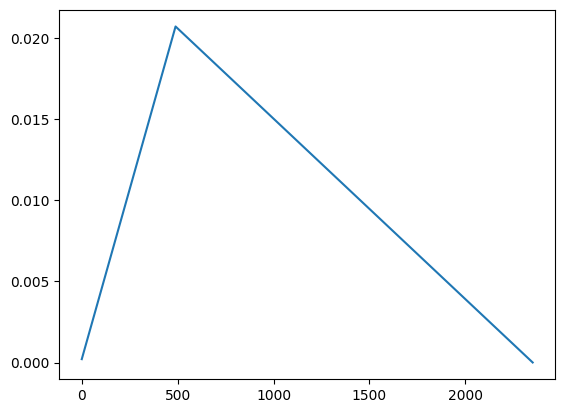

In [9]:
len(lrs)
plt.plot(lrs)

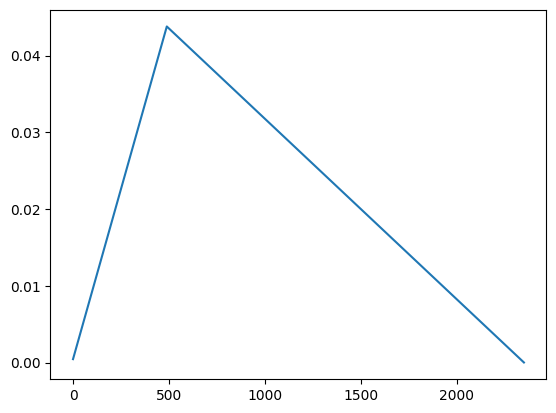

In [9]:
plt.plot(lrs)

In [ ]:
misclassified_images = misclassified_images.cpu()
misclassified_images_actual_label = misclassified_images_actual_label.cpu()
misclassified_images_predicted_label = misclassified_images_predicted_label.cpu()
for i in range(len(misclassified_images)):
    plt.subplot(3,4,i+1)
    im = misclassified_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.title('Act: {}/ Pred: {}'.format(inttoclasses[misclassified_images_actual_label[i].item()], inttoclasses[misclassified_images_predicted_label[i].item()]))
    plt.axis('off')

In [ ]:
len(misclassified_images)

In [ ]:
model = models.model()
summary(model, input_size=(3, 32, 32))
